In [2]:
## LOADING THE REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import tensorflow as tf
from  tensorflow.keras.preprocessing.sequence import pad_sequences
from  sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, "0" to  "7" 
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4,5,7"

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib

Num GPUs Available:  6


In [2]:
!nvidia-smi

Sat Jan 21 10:44:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |   3581MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [5]:
df= pd.read_csv('DATA/etoori_train.csv')
df.columns = ["enc_input","dec_input"] 
df["dec_output"] = df.dec_input
df.head(2)


,enc_input,dec_input,dec_output
0,परन्तु वे दोनों उन बातों को ज़्यादा समय तक अप ...,परन्तु वे दोनों उन बातों को ज़्यादा समय तक अपन...,परन्तु वे दोनों उन बातों को ज़्यादा समय तक अपन...
1,देश में हिन्दी को विस्थापित कर का षड़यंत्र चल ...,देश में हिन्दी को विस्थापित करने का षड़यंत्र च...,देश में हिन्दी को विस्थापित करने का षड़यंत्र च...


In [6]:
## THE INPUTS TO THE DECODER REQUIRES SPECIAL TOKENS FOR THE START AND THE END SO WE ARE GOING TO USE 
## <start> AS BEGINING TOKEN
## <end>  AS END TOKEN

df["dec_input"]= "<start> " + df["dec_input"]
df["dec_output"] =  df["dec_output"] + " <end>" 
df.head(2)

,enc_input,dec_input,dec_output
0,परन्तु वे दोनों उन बातों को ज़्यादा समय तक अप ...,<start> परन्तु वे दोनों उन बातों को ज़्यादा सम...,परन्तु वे दोनों उन बातों को ज़्यादा समय तक अपन...
1,देश में हिन्दी को विस्थापित कर का षड़यंत्र चल ...,<start> देश में हिन्दी को विस्थापित करने का षड...,देश में हिन्दी को विस्थापित करने का षड़यंत्र च...


In [7]:
df["dec_input"][0]

'<start> परन्तु वे दोनों उन बातों को ज़्यादा समय तक अपने हृदय में गाँठ बनाकर नहीं रखते थे । '

In [8]:
df["dec_output"][0]

'परन्तु वे दोनों उन बातों को ज़्यादा समय तक अपने हृदय में गाँठ बनाकर नहीं रखते थे ।  <end>'

In [9]:
df_train ,df_val = train_test_split(df,test_size=0.2,random_state = 3)

In [10]:
## IN THE COLUMN WHICH HAS DECODER INPUTS ADDING "<end>" TOKEN TO BE LEARNED BY THE TOKENIZER
df_train["dec_input"].iloc[0]  = df_train.iloc[0]["dec_input"] + " <end>"
df_train.shape

(112000, 3)

In [11]:
df_val.shape

(28000, 3)

In [12]:
""" Tokenisation """
from indicnlp.tokenize import indic_tokenize
def tokenization(indic_string):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(indic_string):
        if t != '<' or t != '>' or t != 'start' or t != 'end':
            tokens.append(t)
    return tokens

In [13]:
enc_token_ip = df_train['enc_input'].apply(lambda x: tokenization(x))
print(type(enc_token_ip))
enc_token_ip

<class 'pandas.core.series.Series'>


1522      [अवध, के, माटी, रतनों, को, ढूंढने, वाली, इस, स...
107460                       [यही, तो, कला, के, दिन, है, ।]
134546    [इसीलिए, तो, जिधर, सिर, मुडाता, हूँ, ओले, उसी,...
120290    [फोन, पर, बात, बंद, हुई, तो, सीआई, रोते, हुए, ...
109794                     [परिजनों, ने, उसे, थेने, लाए, ।]
                                ...                        
11261                        [प्रायः, झपट्टा, मारती, है, ।]
104704    [अप, गांव, को, उन्नत, कर, का, उनका, एक, दीर्घक...
48056     [लेकिन, कई, क्षेत्र, ऐसे, हैंं, जहां, इस, लाइन...
77049     [वास्तव, में, हज़रत, अली, अलैहिस्सलाम, साहस, औ...
71530     [सुप्रीम, कोर्ट, दो, साल, से, ज्यादा, की, सजा,...
Name: enc_input, Length: 112000, dtype: object

In [14]:
vocab_ip= {}
vocab_ip['<unk>']=0
count= 0 
for i in enc_token_ip:
    for j in i:
        if j not in vocab_ip:
            count=count+1
            vocab_ip[j]=count
        else:
            continue
vocab_ip_length= len(vocab_ip)
print(vocab_ip_length)
print(type(vocab_ip))
#print(vocab_ip)

73829
<class 'dict'>


In [15]:
#vocab_ip

In [16]:
from indicnlp.tokenize import indic_tokenize

def tokenization(indic_string):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(indic_string):

        if t != '<' and t != '>' and t != 'start' and t != 'end':
            tokens.append(t)
    tokens.insert(0,'<start>')
    tokens.append('<end>')
    return tokens


dec_token_ip = df_train['dec_input'].apply(lambda x: tokenization(x))

print(type(dec_token_ip))


<class 'pandas.core.series.Series'>


In [17]:
vocab_dec= {}
vocab_dec['<unk>']=0
count= 0 
for i in dec_token_ip:
    for j in i:
        if j not in vocab_dec:
            count=count+1
            vocab_dec[j]=count
        else:
            continue

print(len(vocab_dec))
print(type(vocab_dec))
#print(vocab_dec)
vocab_dec_length=len(vocab_dec)

72971
<class 'dict'>


In [18]:
print(vocab_dec['<end>'])
vocab_dec['<start>']

20


1

In [19]:
"""# Glove embeddings """

embeddings_index = dict()

with open ("models/hi-d300-glove.txt", encoding="utf8", errors='ignore') as f: 

    for line in f:

        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
   
f.close()

print('loaded glove vectors')

loaded glove vectors


In [20]:
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
glove_filename = "hi-d300-glove.txt"
word2vec_output_file = glove_filename+'.word2vec'
glove_path = "models/hi-d300-glove.txt"
word2vec_output_file

'hi-d300-glove.txt.word2vec'

In [21]:
len(embeddings_index)

1732951

In [22]:
word = "पूजा"
embeddings_index.get(word).shape[0]

300

In [23]:
word = "पूजा"
print("Embedding Shape is {}".format(embeddings_index.get(word).shape[0]))
print("Nearest Neighbors to {} using Glove are:".format(word))



Embedding Shape is 300
Nearest Neighbors to पूजा using Glove are:


In [24]:
#embeddings_index.most_similar(word)

In [43]:
## FORMING EMBEDDING MATRIX FOR encoder SENTENCE
Embedding_dimensions=300
import numpy as np
embedding_matrix_enc = np.zeros((vocab_ip_length,Embedding_dimensions))

for word, i in vocab_ip.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_enc[i] = embedding_vector

print(embedding_matrix_enc.shape)

print(embedding_matrix_enc)
#embedding_matrix_fasttext_enc

(73829, 300)
[[ 0.013644    0.037186   -0.018494   ... -0.004903    0.023412
   0.01087   ]
 [-0.472978   -0.23835599 -0.46332401 ... -0.025699   -0.50801802
   0.014579  ]
 [-1.28005195 -1.167081    0.087567   ... -0.13499101 -0.88774598
   0.325504  ]
 ...
 [ 0.033654   -0.056473    0.19569001 ... -0.201353   -0.018469
  -0.119836  ]
 [-0.027771    0.128667   -0.077422   ... -0.024443    0.056033
  -0.043912  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [44]:
len(embedding_matrix_enc[0])

300

In [45]:
## FORMING EMBEDDING MATRIX FOR decoder SENTENCE
Embedding_dimensions=300
import numpy as np
embedding_matrix_dec  = np.zeros((vocab_dec_length,Embedding_dimensions))

for word, i in vocab_dec.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_dec[i] = embedding_vector
        
print(embedding_matrix_dec.shape)

print(embedding_matrix_dec)
#embedding_matrix_fasttext_dec

(72971, 300)
[[ 0.013644    0.037186   -0.018494   ... -0.004903    0.023412
   0.01087   ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.472978   -0.23835599 -0.46332401 ... -0.025699   -0.50801802
   0.014579  ]
 ...
 [-0.36101699 -0.103008   -0.007559   ... -0.044359   -0.37095201
   0.28727201]
 [ 0.033654   -0.056473    0.19569001 ... -0.201353   -0.018469
  -0.119836  ]
 [-0.027771    0.128667   -0.077422   ... -0.024443    0.056033
  -0.043912  ]]


In [46]:
from sklearn.manifold import TSNE

In [47]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
#two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
two_d_embeddings = tsne.fit_transform(embedding_matrix_dec[1:num_points+1, :])


In [35]:
from matplotlib.font_manager import FontProperties
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline
hindi_font = FontProperties(fname='models/Nirmala.ttf')

In [36]:
from matplotlib import pylab
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=hindi_font)
    pylab.show()



In [37]:
#list(vocab_dec.keys())

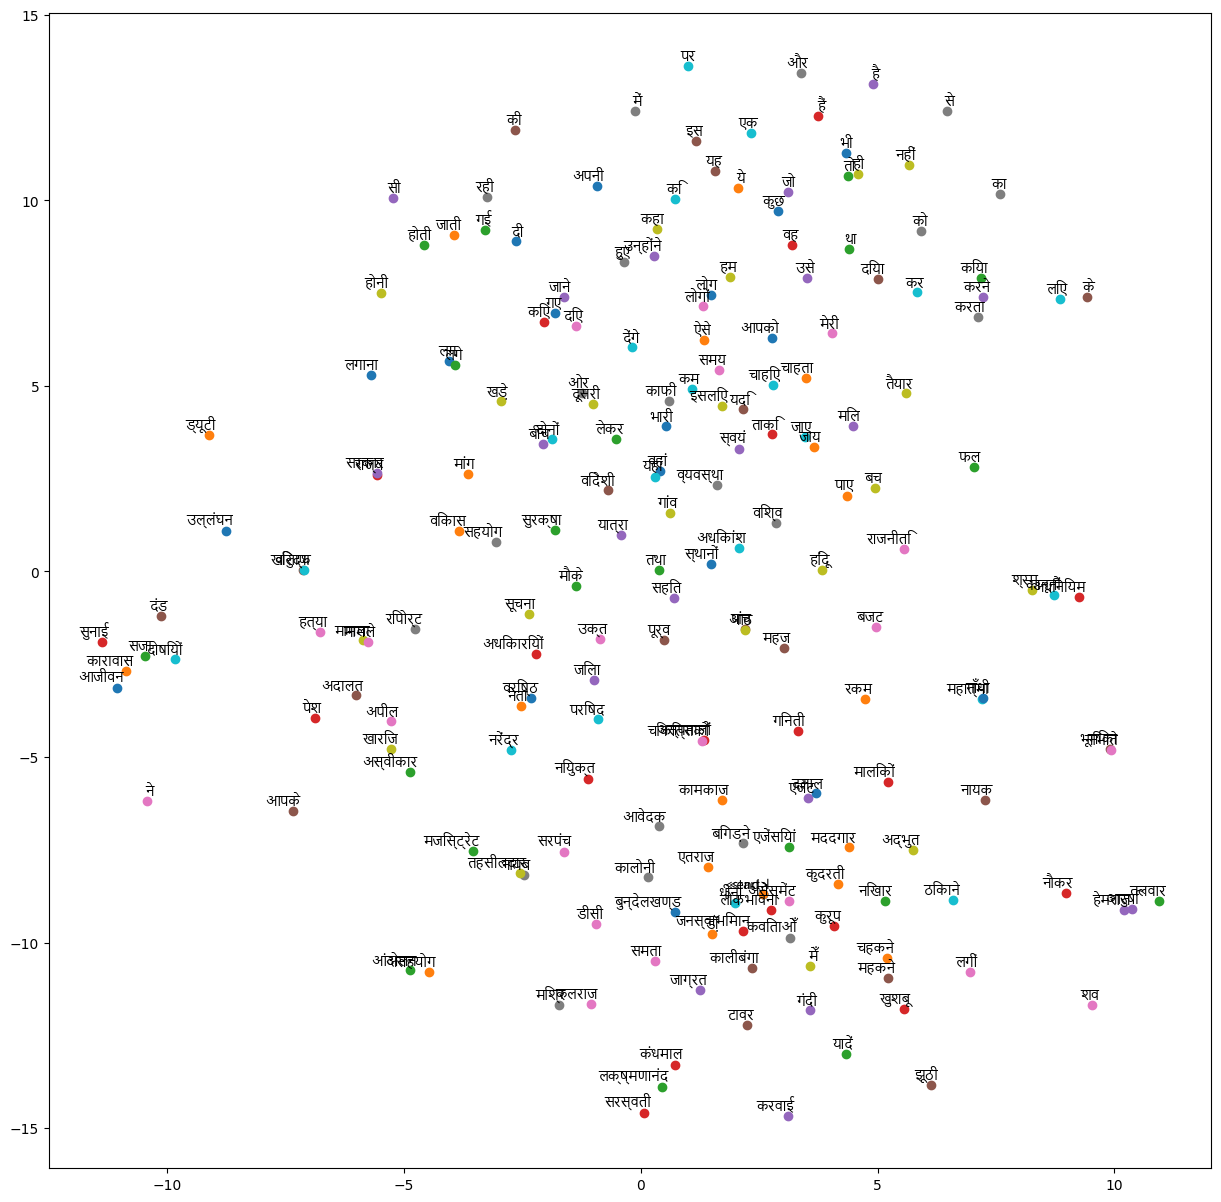

In [38]:

words = list(vocab_dec.keys())[1:num_points+1]
#word = "पूजा"
plot(two_d_embeddings, words)


In [27]:
"""# Data Pipeline"""

print([df_train["enc_input"].apply(str).values[0]])

['अवध के माटी रतनों को ढूंढने वाली इस संस्था और इससे जुड़े लोगों का मकसद बड़ा हैं ।']


In [28]:
def texts_to_sequences1(s):
    l=[]
    bigl=[]
    s=s[0]
    #print(s)
    ts= s.split()
    #print(ts)
    for w in ts:
        if w in vocab_ip:
            l.append(vocab_ip[w])
        else:
            l.append(vocab_ip['<unk>'])
    bigl.append(l)
    l = []
    return bigl

In [29]:
def texts_to_sequences2(s):
    l=[]
    bigl=[]
    s=s[0]
    #print(s)
    ts= s.split()
    #print(ts)
    for w in ts:
        if w in vocab_dec:
            l.append(vocab_dec[w])
        else:
           l.append(vocab_dec['<unk>'])  
    bigl.append(l)
    l = []
    return bigl

In [30]:
a = texts_to_sequences1([df_train["enc_input"].apply(str).values[0]])
b = texts_to_sequences2([df_train["enc_input"].apply(str).values[0]])

print([df_train["enc_input"].apply(str).values[0]])
print(len(a[0]))
print(a)
print(len(b[0]))
print(b)

['अवध के माटी रतनों को ढूंढने वाली इस संस्था और इससे जुड़े लोगों का मकसद बड़ा हैं ।']
18
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
18
[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 19]]


In [31]:
#THIS CLASS CONVERTS TEXT DATA TO INTEGER SEQUENCES AND RETURNS THE PADDED SEQUENCES
class Dataset :
    def __init__(self, data ,texts_to_sequences1,texts_to_sequences2, max_len):
        ## SETTING THE REQUIRED ATTRIBUTES
        self.encoder_inp = data["enc_input"].apply(str).values
        self.decoder_inp = data["dec_input"].apply(str).values
        self.decoder_out = data["dec_output"].apply(str).values
        self.max_len = max_len
        self.texts_to_sequences1=texts_to_sequences1
        self.texts_to_sequences2= texts_to_sequences2

        
    def __getitem__(self,i):
        # INPUT SEQUENCES
        self.encoder_seq = self.texts_to_sequences1([self.encoder_inp[i]])
        #print(self.encoder_seq)

        # DECODER INPUT SEQUENCES 
        self.decoder_inp_seq = self.texts_to_sequences2([self.decoder_inp[i]])
        # DECODER INPUT SEQUENCES
        self.decoder_out_seq = self.texts_to_sequences2([self.decoder_out[i]])
        
        # PADDING THE ENCODER INPUT SEQUENCES
        self.encoder_seq = pad_sequences(self.encoder_seq, padding="post",maxlen = self.max_len)
        # PADDING THE DECODER INPUT SEQUENCES
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, padding="post",maxlen = self.max_len)
        # PADDING DECODER OUTPUT SEQUENCES
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq ,padding="post", maxlen = self.max_len)

        ##  RETURNING THE ENCODER INPUT , DECODER INPUT , AND DECODER OUTPUT
        return self.encoder_seq ,  self.decoder_inp_seq,  self.decoder_out_seq
    
    def __len__(self):
        # RETURN THE LEN OF INPUT ENDODER
        return len(self.encoder_inp)


In [32]:
# THIS CLASS CONVERTES THE DATASET INTO THE REQUIRED BATCH SIZE

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,batch_size,dataset):
        # INTIALIZING THE REQUIRED VARIABLES 
        self.dataset = dataset
        self.batch_size = batch_size
        self.totl_points = self.dataset.encoder_inp.shape[0]
        
    def __getitem__(self,i):
        # STATING THE START AND STOP VATIABLE CONTAINGING INDEX VALUES FOR EACH BATCH
        start = i * self.batch_size
        stop = (i+1)*self.batch_size
        
        # PLACEHOLDERS FOR BATCHED DATA
        batch_enc =[]
        batch_dec_input = []
        batch_dec_out =[]

        for j in range(start,stop): 
            
            a,b,c = self.dataset[j] 
            batch_enc.append(a[0]) 
            batch_dec_input.append(b[0])
            batch_dec_out.append(c[0]) 
        
        # Conveting list to array   
        batch_enc = (np.array(batch_enc)) 
        batch_dec_input = np.array(batch_dec_input)
        batch_dec_out = np.array(batch_dec_out)
        
        ## RETURNING BATCHED DATA IN REQUIRED FORM
        return [batch_enc , batch_dec_input], batch_dec_out  

    def __len__(self):
        # Returning the number of batches
        return int(self.totl_points/self.batch_size)


In [33]:
# FORMING OBJECTS OF DATASET AND DATALOADER FOR TRAIN DATASET
train_dataset = Dataset(df_train,texts_to_sequences1,texts_to_sequences2,35)
#print(train_dataset)
train_dataloader = Dataloader( batch_size = 32, dataset=train_dataset)

In [34]:
# FORMING OBJECTS OF DATASET AND DATALOADER FOR VALIDATION DATASET
val_dataset = Dataset(df_val ,texts_to_sequences1,texts_to_sequences2,35)
val_dataloader = Dataloader(batch_size=32, dataset=val_dataset)

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [36]:
"""# Word Level Fasttext Attention Model"""

## DEFINING THE ENCODER LAYER AS A FUNCTION
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, vocab_size,emb_dims, enc_units, input_length,batch_size):
        super().__init__()
        # INITIALIZING THE REQUIRED VARIABLES
        self.batch_size=batch_size # BATCH SIZE
        self.enc_units = enc_units # ENCODER UNITS

        # EMBEDDING LAYER
        self.embedding= layers.Embedding(vocab_size ,emb_dims ,weights=[embedding_matrix_enc], mask_zero = True, trainable=False) 
        # LSTM LAYER WITH RETURN SEQ AND RETURN STATES
        self.lstm = layers.LSTM(self.enc_units,return_state= True,return_sequences =  True) 
    
    def call(self, enc_input , states):
        
        # FORMING THE EMBEDDED VECTOR 
        emb = self.embedding(enc_input)
        # PASSING THE EMBEDDED VECTIO THROUGH LSTM LAYERS 
        enc_output,state_h,state_c = self.lstm(emb,initial_state=states)
        #RETURNING THE OUTPUT OF LSTM LAYER
        return enc_output,state_h,state_c 
    def initialize(self,batch_size):

        return tf.zeros(shape=(batch_size,self.enc_units)),tf.zeros(shape=(batch_size,self.enc_units))

In [37]:
# THIS IS ATTNETION LAYER FOR DOT MODEL
class Attention(tf.keras.layers.Layer):
    
    def __init__(self,units):
        super().__init__()
        # INITIALIZING THE DENSE LAYER W1
        self.W1 = layers.Dense(units)
        # INITIALIZING THE DENSE LAYER W2
        self.W2 = layers.Dense(units)
        # INITIALIZING THE DENSE LAYER V
        self.v = layers.Dense(1)
        
    def call(self,enc_output,dec_state):
        # EXPANDING THE DIMENSION OF DECODER STATE  EG. FROM (16,32) TO (16,32,1)
        dec_state =  tf.expand_dims(dec_state,axis=1)
        
        # FINDING THE SCORE FOR CONCAT MODEL
        score = self.v(tf.nn.tanh(
            self.W1(dec_state)+ self.W2(enc_output)
        ))
        # APPLYING SOFTMAX TO THE AXIS 1
        # OUPUT SHAPE = (16,13,1)
        att_weights = tf.nn.softmax(score,axis=1)
        
        # CALCULATING THE CONTEXT VECTOR BY FIRST ELEMENTWISE MULTIPLICATION AND THEN ADDING THE AXIS 1
        # (16,13,1)*(16,13,32)=(16,13,32)
        context_vec  = att_weights* enc_output
        
        # (16,13,32) SUM AND REDUCE THE DIMENSION AT AXIS 1 => (16,32)
        context_vec = tf.reduce_sum(context_vec,axis=1)
        
        # RETURNING THE CONTEXT VECTOR AND ATTENTION WEIGHTS
        return context_vec,att_weights

In [38]:
class Onestepdecoder(tf.keras.Model):
    '''THIS MODEL OUTPUTS THE RESULT OF DECODER FOR ONE TIME SETP GIVEN THE INPUT FOR PRECIOVE TIME STEP'''
    
    def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size):
        super().__init__()
        # INTITALIZING THE REQUIRED VARIABLES
        # EMBEDDING LAYERS
        self.emb = layers.Embedding(vocab_size,emb_dims,input_length= input_len, weights=[embedding_matrix_dec ], mask_zero = True, trainable=False)
        # ATTENTION LAYER
        self.att = Attention(att_units)
        
        # LSTM LAYER
        self.lstm = layers.LSTM(dec_units,return_sequences=True,return_state=True)
        # DENSE LAYER
        self.dense = layers.Dense(vocab_size,activation="softmax")

    def call(self, encoder_output , input , state_h,state_c):
        # FORMING THE EMBEDDED VECTOR FOR THE WORD
        # (32,1)=>(32,1,12)
        emb = self.emb(input)

        dec_output,dec_state_h,dec_state_c = self.lstm( emb , initial_state = [state_h,state_c] )

        # GETTING THE CONTEXT VECTOR AND ATTENTION WEIGHTS BASED ON THE ENCODER OUTPUT AND  DECODER STATE_H
        context_vec,alphas = self.att(encoder_output,dec_state_h)
        
        # CONCATINATING THE CONTEXT VECTOR(BY EXPANDING DIMENSION) AND ENBEDDED VECTOR
        dense_input =  tf.concat([tf.expand_dims(context_vec,1),dec_output],axis=-1)
        
        # PASSING THE DECODER OUTPUT THROUGH DENSE LAYER WITH UNITS EQUAL TO VOCAB SIZE
        fc = self.dense(dense_input)
        
        # RETURNING THE OUTPUT
        return fc , dec_state_h , dec_state_c , alphas


In [39]:
class Decoder(tf.keras.Model):
    '''THIS MODEL PERFORMS THE WHOLE DECODER OPERATION FOR THE COMPLETE SENTENCE'''
    def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size):
        super().__init__()
        # INITIALIZING THE VARIABLES
        # LENGTH OF INPUT SENTENCE
        self.input_len = input_len
        # ONE STEP DECODER
        self.onestepdecoder = Onestepdecoder(vocab_size,emb_dims, dec_units, input_len,att_units,batch_size)

    def call(self,dec_input,enc_output,state_h,state_c):
        # THIS VATIABLE STORES THE VALUE OF STATE_H FOR THE PREVIOUS STATE
        current_state_h = state_h 
        current_state_c = state_c
        # THIS STORES THE DECODER OUTPUT FOR EACH TIME STEP
        pred = []
        # THIS STORED THE ALPHA VALUES
        alpha_values = []
        # FOR EACH WORD IN THE INPUT SENTENCE
        for i in range(self.input_len):
            
            # CURRENT WORD TO INPUT TO ONE STEP DECODER
            current_vec = dec_input[:,i]

            # EXPANDING THE DIMENSION FOR THE WORD
            current_vec = tf.expand_dims(current_vec,axis=-1)

            # PERFORMING THE ONE STEP DECODER OPERATION 
            dec_output,dec_state_h,dec_state_c,alphas = self.onestepdecoder(enc_output ,current_vec,current_state_h,current_state_c)

            #UPDATING THE CURRENT STATE_H
            current_state_h = dec_state_h
            current_state_c = dec_state_c

            #APPENDING THE DECODER OUTPUT TO "pred" LIST
            pred.append(dec_output)

            # APPENDING THE ALPHA VALUES
            alpha_values.append(alphas)
            
        # CONCATINATING ALL THE VALUES IN THE LIST
        output = tf.concat(pred,axis=1)
        # CONCATINATING ALL THE ALPHA VALUES IN THE LIST
        alpha_values = tf.concat(alpha_values,axis = -1)
        # RETURNING THE OUTPUT
        return output , alpha_values

In [40]:
class encoder_decoder(tf.keras.Model):
    '''THIS MODEL COMBINES ALL THE LAYERS AND FORM IN ENCODER DECODER MODEL WITH ATTENTION MECHANISM'''
    def __init__(self,enc_vocab_size,enc_emb_dim,enc_units,enc_input_length,
             dec_vocab_size,dec_emb_dim,dec_units,dec_input_length ,att_units, batch_size):
        # INITAILIZING ALL VARIABLES
        super().__init__()
        # BATCH SIZE
        self.batch_size = batch_size
        # INITIALIZING ENCODER LAYER
        self.encoder = Encoder(enc_vocab_size, enc_emb_dim,enc_units, enc_input_length,batch_size)
        # INITALIZING DECODER LAYER
        self.decoder = Decoder(dec_vocab_size ,dec_emb_dim,dec_units,dec_input_length  ,att_units, batch_size)

    def call(self,data):
        # THE INPUT OF DATALOADER IS IN A LIST FORM FOR EACH BATCH IT GIVER TWO INPUTS
        # INPUT1 IS FOR ENCODER
        # INPUT2 IS FOR DECODER
        inp1 , inp2 = data
        # PASSING THE INPUT1 TO ENCODER LAYER
        enc_output, enc_state_h, enc_state_c = self.encoder(inp1,self.encoder.initialize(self.batch_size))
        # PASSING INPUT2 TO THE DECODER LAYER
        dec_output , alphas = self.decoder(inp2 , enc_output,enc_state_h,enc_state_c)
        # THE OUTPUT OF MODEL IS ONLY DECODER OUTPUT THE ALPHA VALUES ARE IGNORED HERE
        return dec_output

In [48]:
# INITAILZING THE MODEL
model = encoder_decoder(enc_vocab_size=vocab_ip_length,
                         enc_emb_dim = 300,
                         enc_units=32,
                         enc_input_length=35,
                         dec_vocab_size =vocab_dec_length,
                         dec_emb_dim =300,
                         dec_units=32,
                         dec_input_length = 35,
                         att_units=32,
                         batch_size=32)

In [49]:
callback =[ tf.keras.callbacks.ModelCheckpoint( "models/glove_attn_best_full.h5",save_best_only=True,mode="min" ,save_weights_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,min_delta=0.0001),
            tf.keras.callbacks.TensorBoard("models/glove_attn_save_full",histogram_freq=1)
]

train_steps = train_dataloader.__len__()
val_steps  = val_dataloader.__len__()

model.compile(optimizer="adam",loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
train_steps

3500

In [51]:
#Epoch 36/50
#3500/3500 [==============================] - 946s 270ms/step - loss: 0.0618 - accuracy: 0.9886 - val_loss: 0.3910 - val_accuracy: 0.9615


In [52]:
#model.fit(train_dataloader, steps_per_epoch=train_steps,epochs= 50,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback)

In [53]:
#(batch_size,maxlen)
model.build([(32,35),(32,35)])
model.summary()

Model: "encoder_decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  22191324  
                                                                 
 decoder (Decoder)           multiple                  26679184  
                                                                 
Total params: 48,870,508
Trainable params: 4,830,508
Non-trainable params: 44,040,000
_________________________________________________________________


In [54]:
model.built = True
model.load_weights("models/glove_attn_best_full.h5")

In [55]:
"""# Greedy Search Inferencing"""
vocab_dec_inv = {v: k for k, v in vocab_dec.items()}
print(len(vocab_dec_inv))

72971


In [56]:
def predict(ita_text,model):
    '''THIS FUNCTION IS USED IN INFERENCE TIME WHICH GIVEN ANY SENTENCE IN ITALIAN OUTPUTS THE ENGLISH SENTENCE AND ALPHA VALUES'''
    # FORMING TOKENIZED SEQUENCES FOR INPUT SENTENCE
    seq = texts_to_sequences1([ita_text])
    # PADDING THE SEQUENCES
    seq = pad_sequences(seq,maxlen = 35 , padding="post")
    # INITIALIZING THE STATES FOR INPUTING TO ENCODER
    state = model.layers[0].initialize(1)
    # GETTING THE ENCODED OUTPUT
    enc_output,state_h,state_c= model.layers[0](seq,state)
    # VARIABLE TO STORE PREDICTED SENTENCE
    pred = []
    # THIS VARIABLE STORES THE STATE TO BE INPUTED TO ONE STEP ENCODER
    input_state_h = state_h
    input_state_c = state_c
    # THIS VARIABLE STORES THE VECTOR TO VE INPUTED TO ONE STEP ENCODER
    current_vec = tf.ones((1,1))
    # THIS VARIABLE WILL STORE ALL THE ALPHA VALUES OUTPUTS
    alpha_values = []

    for i in range(35):
        # PASSING THE REQUIRED VARIABLE TO ONE STEP ENCODER LAYER
        fc , dec_state_h ,dec_state_c, alphas = model.layers[1].layers[0](enc_output , current_vec ,input_state_h ,input_state_c)
        #APPENDING THE ALPHA VALUES TO THE LIST "alpha_values"
        alpha_values.append(alphas)
         # UPDATING THE CURRENT VECTOR 
        current_vec = np.argmax(fc , axis = -1)
         # UPDATING THE INPUT STATE
        input_state_h = dec_state_h
        input_state_c = dec_state_c

        # GETTING THE ACTUAL WORDS FRO THE TOKENIZED INDEXES
        #print([current_vec[0][0]])
        #print(vocab_dec[current_vec[0][0]])
        #print(vocab_dec.index(current_vec[0][0]))
        pred.append(vocab_dec_inv[current_vec[0][0]])
        # IF THE WORD "<end>" COMES THE LOOP WILL BREAK
        if vocab_dec_inv[current_vec[0][0]]=="<end>":
              break

    # JOINING THE PREDICTED WORDS
    pred_sent = " ".join(pred)
    # CONCATINATING ALL THE ALPHA VALUES
    alpha_values = tf.squeeze(tf.concat(alpha_values,axis=-1),axis=0)
    # RETURNING THE PREDICTED SENTENCE AND ALPHA VALUES
    return  pred_sent , alpha_values


In [57]:
#Testing on Train Data
print("Incorrect Sentence: ", df_train['enc_input'].apply(str).values[10])
print("Actual Correct Sentence: ", df_train['dec_output'].apply(str).values[10])
print("Predicted Correct Sentence: ", predict(df_train['enc_input'].apply(str).values[10],model)[0])


Incorrect Sentence:  हमारे पास काम कर के लिए राजा के दर्जी थे ।
Actual Correct Sentence:  हमारे पास काम करने के लिए राजा के दर्जी थे ।  <end>


2023-01-21 11:05:16.924255: W tensorflow/stream_executor/cuda/cuda_dnn.cc:339] There was an error before creating cudnn handle: cudaErrorMemoryAllocation : out of memory
2023-01-21 11:05:17.306472: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


Predicted Correct Sentence:  हमारे पास काम करने के लिए राजा के दर्जी था । <end>


In [58]:
print("Incorrect Sentence: ", df_train['enc_input'].apply(str).values[1])
print("Actual Correct Sentence: ", df_train['dec_output'].apply(str).values[1])
print("Predicted Correct Sentence: ", predict(df_train['enc_input'].apply(str).values[1],model)[0])


Incorrect Sentence:  यही तो कला के दिन है ।
Actual Correct Sentence:  यही तो कला के दिन हैं ।  <end>
Predicted Correct Sentence:  यही तो कला के दिन है । <end>


In [59]:

print(df_train['enc_input'].apply(str).values[100])
print(df_train['dec_input'].apply(str).values[100])
print(predict(df_train['enc_input'].apply(str).values[100],model)[0])

इन किसानों का साफ़ कहना है की इस भुंड का इन फसलों में इतना भी नुकशान नही होता जितना की हम इसके नियंत्रण के लिए कीटनाशकों पर खर्च देते है ।
<start> इन किसानों का साफ़ कहना है की इस भुंड का इन फसलों में इतना भी नुकशान नही होता जितना की हम इसके नियंत्रण के लिए कीटनाशकों पर खर्च देते हैं । 
इन किसानों का साफ़ कहना है की इस भुंड का इन फसलों में इतना भी नुकशान नही होता जितना की हम इसके नियंत्रण के लिए कीटनाशकों पर खर्च देते हैं । <end>


In [50]:

print(df_train['enc_input'].apply(str).values[50])
print(df_train['dec_input'].apply(str).values[1])
print(predict(df_train['enc_input'].apply(str).values[50],model)[0])

मै कहा दूध बेचता हूं ।
<start> यही तो कला के दिन हैं । 
मैने कहा दूध बेचता हूं । <end>


In [60]:
import nltk.translate.bleu_score as bleu
BLEU = []
index = []
np.random.seed(1)
test_data = df_val.loc[np.random.choice(df_val.index,size = 100,replace=False)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model)[0].split()
        act = [str(i.dec_output).split()]
        b = bleu.sentence_bleu(act,pred)
        BLEU.append(b)
    except:
        index.append(ind)
        continue
print("BELU = ", np.mean(BLEU))

100it [00:20,  4.82it/s]

BELU =  0.7959087777716927


In [52]:
import nltk.translate.bleu_score as bleu
BLEU = []
index = []
np.random.seed(1)
test_data = df_val.loc[np.random.choice(df_val.index,size = 1000,replace=False)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model)[0].split()
        act = [str(i.dec_output).split()]
        b = bleu.sentence_bleu(act,pred)
        BLEU.append(b)
    except:
        index.append(ind)
        continue
print("BELU = ", np.mean(BLEU))

1000it [03:52,  4.30it/s]

BELU =  0.8146864083085562


In [53]:
## HERE I AM SAMPLING 1000 POINTS FROM THE DATAFRAME AS TEST DATA WHICH ARE NOT PRESEENT IN THE TRAIN AND VALIDAION DATA
np.random.seed(5) 
df_test = df.loc[np.random.choice(np.array([x for x in df.index.values]),1000,replace= False,)]
df_test

,enc_input,dec_input,dec_output
80240,हमें आने वाले हफ्तों में रोवियो मोबाइल द्वारा ...,<start> हमें आने वाले हफ्तों में रोवियो मोबाइल...,हमें आने वाले हफ्तों में रोवियो मोबाइल द्वारा ...
32433,आज कमेन्ट मोदेरेशन सक्षम हैंं ।,<start> आज कमेन्ट मोदेरेशन सक्षम हैं ।,आज कमेन्ट मोदेरेशन सक्षम हैं । <end>
135530,राजस् थेन स्कूल टीचर्स यूनियन के अध्यक्ष आर पी...,<start> राजस् थान स्कूल टीचर्स यूनियन के अध्यक...,राजस् थान स्कूल टीचर्स यूनियन के अध्यक्ष आर पी...
3354,सेक्स का कारक ग्रह भी शुक्र ही हैं तथा शुक्र ए...,<start> सेक्स का कारक ग्रह भी शुक्र ही है तथा ...,सेक्स का कारक ग्रह भी शुक्र ही है तथा शुक्र एक...
125119,वह एक गिलास शर्बत,<start> उसने एक गिलास शर्बत,उसने एक गिलास शर्बत <end>
...,...,...,...
123821,बीकॉम ऑनर्स और इको ऑनर्स कोर्स स्टूडेंट की पसं...,<start> बीकॉम ऑनर्स और इको ऑनर्स कोर्स स्टूडें...,बीकॉम ऑनर्स और इको ऑनर्स कोर्स स्टूडेंट की पसं...
40525,मरने वालों में बस में सवार यात्री थी ।,<start> मरने वालों में बस में सवार यात्री थे ।,मरने वालों में बस में सवार यात्री थे । <end>
72286,यान्त्रिक रूप से क्षमा मांगना सम्पर्क बढ़ा का ...,<start> यान्त्रिक रूप से क्षमा मांगना सम्पर्क ...,यान्त्रिक रूप से क्षमा मांगना सम्पर्क बढ़ाने क...
90240,मैंनेने इस शहर में खुद का स् वागत बांहें खोलकर...,<start> मैंने इस शहर में खुद का स् वागत बांहें...,मैंने इस शहर में खुद का स् वागत बांहें खोलकर न...


In [54]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model)[0])
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता थे और कड़ी मेहनत करनी पड़ती थी ।
PREDICTED SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी । <end>
ACTUAL SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी ।  <end>


In [55]:
%%time
predict(df_test.enc_input.values[50],model)[0]

CPU times: user 282 ms, sys: 542 µs, total: 283 ms
Wall time: 253 ms


'नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती है । <end>'

In [56]:
import nltk.translate.bleu_score as bleu
BLEU = []
index = []
np.random.seed(1)
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000,replace=False)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model)[0].split()
        act = [str(i.dec_output).split()]
        b = bleu.sentence_bleu(act,pred)
        BLEU.append(b)
    except:
        index.append(ind)
        continue
print("BELU = ", np.mean(BLEU))

2000it [07:36,  4.39it/s]

BELU =  0.8159367288252909


In [57]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model)[0])
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता थे और कड़ी मेहनत करनी पड़ती थी ।
PREDICTED SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी । <end>
ACTUAL SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी ।  <end>


In [58]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[50],model)[0])
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[50])

INPUT SENTENCE ===>  नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती हैं ।
PREDICTED SENTENCE ===>  नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती है । <end>
ACTUAL SENTENCE ===>  नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती है ।  <end>


In [59]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[4])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[4],model))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[4])

INPUT SENTENCE ===>  वह एक गिलास शर्बत
PREDICTED SENTENCE ===>  ('वह एक गिलास शर्बत <end>', <tf.Tensor: shape=(35, 5), dtype=float32, numpy=
array([[1.0000000e+00, 3.6630947e-08, 5.7227121e-09, 1.4769330e-10,
        9.3618815e-05],
       [1.0443660e-10, 9.9998021e-01, 1.9492575e-06, 1.8300417e-13,
        1.2366443e-06],
       [6.4328203e-13, 1.9755442e-05, 9.9999774e-01, 1.1775008e-09,
        1.5472627e-04],
       [8.1972562e-12, 7.4789652e-10, 3.4041929e-07, 1.0000000e+00,
        9.9975044e-01],
       [1.2740434e-14, 3.2247504e-23, 6.1063893e-22, 2.0257875e-24,
        3.7114873e-14],
       [1.2740434e-14, 3.2247504e-23, 6.1063893e-22, 2.0257875e-24,
        3.7114873e-14],
       [1.2740434e-14, 3.2247504e-23, 6.1063893e-22, 2.0257875e-24,
        3.7114873e-14],
       [1.2740434e-14, 3.2247504e-23, 6.1063893e-22, 2.0257875e-24,
        3.7114873e-14],
       [1.2740434e-14, 3.2247504e-23, 6.1063893e-22, 2.0257875e-24,
        3.7114873e-14],
       [1.2740434e-14, 3.224750

In [60]:
#k_beams
#vocab_dec['<end>']
vocab_dec_inv[32]

'उसी'

In [61]:
def beam_search(input,model,k):
    #seq = tk_inp.texts_to_sequences([input])
    seq = texts_to_sequences1([input])
    seq = pad_sequences(seq,maxlen = 35,padding="post")

    state = model.layers[0].initialize(1)
    # GETTING THE ENCODED OUTPUT
    enc_output,enc_state_h,enc_state_c = model.layers[0](seq,state)
    

    input_state_h = enc_state_h
    input_state_c = enc_state_c 
    k_beams = [[tf.ones((1,1),dtype=tf.int32),0.0]]
    for i in range(35):
        candidates = []
        for sent_pred , prob in k_beams :
            #if tk_out.word_index["<end>"] in sent_pred.numpy() :
            if vocab_dec["<end>"] in sent_pred.numpy() :
                candidates += [[sent_pred , prob]]
            else:
               
                dec_input = model.layers[1].layers[0].layers[0](sent_pred)
                dec_output , dec_state_h , dec_state_c   =  model.layers[1].layers[0].layers[2](dec_input ,  initial_state =  [input_state_h , input_state_c])

                context_vec , alphas =  model.layers[1].layers[0].layers[1](enc_output,dec_state_h)

                # CONCATINATING THE CONTEXT VECTOR(BY EXPANDING DIMENSION) AND ENBEDDED VECTOR
                dense_input =  tf.concat([tf.expand_dims(context_vec,1),tf.expand_dims(dec_state_h,1)],axis=-1)
                
                # PASSING THE DECODER OUTPUT THROUGH DENSE LAYER WITH UNITS EQUAL TO VOCAB SIZE
                dense = model.layers[1].layers[0].layers[3](dense_input)

                pred = tf.argsort(dense, direction= 'DESCENDING')[:,:,:k]
                for w in range(k):
                  candidates += [[tf.concat((sent_pred, pred[:,:,w]) , axis=-1) , (prob + tf.math.log(dense[:,:,pred[:,:,w][0][0]])[0][0])]  ]
        #print("Here2")
        k_beams = sorted(candidates,key=lambda tup:tup[1],reverse=True)[:k]
        #print("kbeams",k_beams)

    all_sent = []
    for i,score in k_beams:
        #print("i",i)
        #print("score",score)
        sent = ""
        for j in range(1,35):
            #print("index",i.numpy()[:,j][0])
            sent +=vocab_dec_inv[i.numpy()[:,j][0]] +  " " 
            #sent +=  tk_out.index_word[i.numpy()[:,j][0]] +  " " 
            #if tk_out.index_word[i.numpy()[:,j][0]] =="<end>":
            if vocab_dec_inv[i.numpy()[:,j][0]] =="<end>":
                break
        #print("done")
        all_sent.append((sent.strip(),score.numpy()))
    return all_sent

In [68]:
# VALIDATION BELU SCORE
BLEU_beam = []
index = []
np.random.seed(1)
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000,replace=False)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = beam_search(str(i.enc_input),model,3)[0][0].split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        BLEU_beam.append(b)
    except:
        #print("Here")
        index.append(ind)
        continue

print("BELU Score = ",np.mean(BLEU_beam)) 

2000it [36:07,  1.08s/it]

BELU Score =  0.82905157148025


In [ ]:
print("BELU Score = ",np.mean(BLEU_beam)) 

In [63]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("="*50)
print("ACTUAL OUTPUT ===> ",df_test.dec_output.values[19])
print("="*50)
print("BEAM SEARCH OUTPUT ,  SCORE")
bm = (beam_search(df_test.enc_input.values[19],model,3))
for i in bm:
    print(i)

INPUT SENTENCE ===>  वह जमाना गया जब धन कमाने में काफी समय लगता थे और कड़ी मेहनत करनी पड़ती थी ।
ACTUAL OUTPUT ===>  वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी ।  <end>
BEAM SEARCH OUTPUT ,  SCORE
('वह जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी । <end>', -0.2827615)
('उसने जमाना गया जब धन कमाने में काफी समय लगता था और कड़ी मेहनत करनी पड़ती थी । <end>', -1.6583035)
('वह जमाना गया जब धन कमाने में काफी समय लगता थी और कड़ी मेहनत करनी पड़ती थी । <end>', -4.119545)


In [64]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("="*50)
print("ACTUAL OUTPUT ===> ",df_test.dec_output.values[50])
print("="*50)
print("BEAM SEARCH OUTPUT ,  SCORE")
bm = (beam_search(df_test.enc_input.values[50],model,3))
for i in bm:
    print(i)

INPUT SENTENCE ===>  नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती हैं ।
ACTUAL OUTPUT ===>  नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती है ।  <end>
BEAM SEARCH OUTPUT ,  SCORE
('नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती है । <end>', -0.65841067)
('नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर खीच लाती हैं । <end>', -2.90524)
('नारों की आवाज मुखिया को ठीक उसी तरह खीच लाई जैसे बीन की धुन सांप को बाहर नहीं है । <end>', -4.4989953)


# Perfformance analysis on test data

In [62]:
# On test dataset
df_test1= pd.read_csv("DATA/etoori_test.csv")
df_test1.columns = ["enc_input","dec_input"] 
df_test1["dec_output"] = df_test1.dec_input
print(df_test1.shape)
df_test1

(30000, 3)


,enc_input,dec_input,dec_output
0,इसके अलावा माइकल शूमाकर द्वारा चलाई गई एक फरार...,इसके अलावा माइकल शूमाकर द्वारा चलाई गई एक फरार...,इसके अलावा माइकल शूमाकर द्वारा चलाई गई एक फरार...
1,यह मन को काबू में करने वाली मुद्रा हैं इसीलिए ...,यह मन को काबू में करने वाली मुद्रा है इसीलिए इ...,यह मन को काबू में करने वाली मुद्रा है इसीलिए इ...
2,आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा उसनेाँ...,आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा वहाँ प...,आप पुस्तक पढ़ने में तल्लीन हैं और बच्चा वहाँ प...
3,परिवार के मुताबिक धमाकों में हिस्सा लेने वाले ...,परिवार के मुताबिक धमाकों में हिस्सा लेने वाले ...,परिवार के मुताबिक धमाकों में हिस्सा लेने वाले ...
4,उनकी वो वाली बात भी अनिश्चित रहती हैं ।,उनकी वो वाली बात भी अनिश्चित रहती है ।,उनकी वो वाली बात भी अनिश्चित रहती है ।
...,...,...,...
29995,पालिश घर्षक मशीनें करती हैंं ।,पालिश घर्षक मशीनें करती हैं ।,पालिश घर्षक मशीनें करती हैं ।
29996,पहले पाकिस्तान ने हमले में भारत का हाथ बताया औ...,पहले पाकिस्तान ने हमले में भारत का हाथ बताया औ...,पहले पाकिस्तान ने हमले में भारत का हाथ बताया औ...
29997,सारे का सारा दर्द उन्हों अप ह्रदय में ही समेट ...,सारे का सारा दर्द उन्होंने अपने ह्रदय में ही स...,सारे का सारा दर्द उन्होंने अपने ह्रदय में ही स...
29998,विल्सन ने लिखे पत्र में रिपब्लिकन सांसदों से भ...,विल्सन ने लिखे पत्र में रिपब्लिकन सांसदों से भ...,विल्सन ने लिखे पत्र में रिपब्लिकन सांसदों से भ...


In [64]:
df_test1 = df_test1.head(10000)
df_test1["dec_input"]= "<start> " + df_test1["dec_input"]
df_test1["dec_output"] =  df_test1["dec_output"] + " <end>" 

# Performance Analysis of pretrained Seq2Seq Attention Model with Word2Vec (10k data points)
1. BLEU Score (Greedy Search: 0.77966)
2. GLEU Score
3. F0.5 Score

# BLEU Score

In [67]:
import nltk.translate.bleu_score as bleu
BLEU_val_emb = []
test_data = df_test1
print(test_data.shape)
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        #pred = predict(str(i.enc_input),model)[0].split()
        pred = predict(str(i.enc_input),model)[0].split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        #print("BELU Score",b)
        BLEU_val_emb.append(b)
    except:
        continue
print("BELU Score = ",np.mean(BLEU_val_emb))

(10000, 3)


10000it [39:52,  4.18it/s]

BELU Score =  0.820024537783515


In [ ]:
import nltk.translate.bleu_score as bleu
BLEU_val_emb = []
test_data = df_test1
print(test_data.shape)
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = beam_search(str(i.enc_input),model,3)[0][0].split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        BLEU_val_emb.append(b)
    except:
        continue
print("BELU Score = ",np.mean(BLEU_val_emb))

# GLEU Score

In [65]:
from nltk.translate.gleu_score import sentence_gleu

In [66]:
GLEU_val_emb = []
test_data = df_test1.head(10000)
print(test_data.shape)
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        #pred = predict(str(i.enc_input),model)[0].split()
        pred = predict(str(i.enc_input),model)[0].split()
        act = [str(i.dec_output).split()]
        
        b =sentence_gleu(act,pred)
        #print("BELU Score",b)
        GLEU_val_emb.append(b)
    except:
        continue
print("GELU Score = ",np.mean(GLEU_val_emb))

(10000, 3)


10000it [41:16,  4.04it/s]

GELU Score =  0.7821870060223015
